In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.7.8
IPython 7.18.1

numpy 1.19.2
pandas 1.1.2
torch 1.6.0
transformers 3.3.1


In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

#sns.set(style='whitegrid', palette='muted', font_scale=1.2)

#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

#rcParams['figure.figsize'] = 10, 8

import random
import numpy as np
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import logging
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.decomposition import PCA
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , log_loss, accuracy_score, balanced_accuracy_score
import seaborn as sn
import copy
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from collections import Counter
from copy import deepcopy
from scipy import sparse
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Sequential, initializers, regularizers, constraints
from tensorflow.keras.layers import GRU, LSTM , Layer , Dense, Dropout, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tqdm import tqdm
from tensorflow.keras.initializers import Zeros,glorot_uniform #RandomUniform
from tqdm import tqdm
%matplotlib inline
import csv 
from tensorflow.keras.models import model_from_json
import pickle


# try to read it as pandas dataframe
df = pd.read_pickle("calls_ver2.pkl", compression=None)
N = len(df)
agent_duration_secs = []
agent_largest_monologue_secs = []
agent_words_per_minute = []
customer_duration_secs = []
customer_largest_monologue_secs = []
duration_secs = []
intents = []
interrupts_by_agent = []
interrupts_by_customer = []
overall_intent = []
patience_secs = []
switches = []
actor = [] 
dialogues = [] 
 
counter = 0
for i in range(N):
    j = df[i]
    overall_intent.append(j.overall_intent)
    agent_duration_secs.append(j.agent_duration_secs)
    agent_largest_monologue_secs.append(j.agent_largest_monologue_secs)
    agent_words_per_minute.append(j.agent_words_per_minute)
    customer_duration_secs.append(j.customer_duration_secs)
    customer_largest_monologue_secs.append(j.customer_largest_monologue_secs)
    duration_secs.append(j.duration_secs)
    interrupts_by_agent.append(j.interrupts_by_agent)
    interrupts_by_customer.append(j.interrupts_by_customer)
    patience_secs.append(j.patience_secs)
    switches.append(j.switches)
    #read the data of each segment
    seg = j.segments
    NN = len(seg)
    speaker = NN*[0]
    seg_intent = NN*[0]
    seg_sentence = [0]*NN
    for k in range(NN):
        speaker[k] = seg[k].actor
        seg_intent[k] = seg[k].intent 
        seg_sentence[k] = seg[k].sentence    
    actor.append(speaker)
    intents.append(seg_intent)
    dialogues.append(seg_sentence)

    
# gather info from all sentences
sent_actor = [item for sublist in actor for item in sublist]
sent_intent = [item for sublist in intents for item in sublist]
sentences = [item for sublist in dialogues for item in sublist]
#pro_sentences = [item for sublist in pro_dialogues for item in sublist]
words = [item for sublist in sentences for item in sublist]
#pro_words = [item for sublist in pro_sentences for item in sublist]
vocabulary = set(words)
#pro_vocabulary = set(pro_words)
print(len(vocabulary))
#print(len(pro_vocabulary))

arthra = ['ο', 'του', 'τον', 'οι', 'των', 'τουσ', 'η', 'τησ' ,'την', 'τη', 'τισ', 'το', 'τα', 'στα', 'στο', 'στον', 'στουσ']
prothemata = ['να', 'απο', 'από', 'και', 'επί', 'επι']
antwnumies = ['μου', 'με', 'σου', 'σε', 'σας','σασ']
staggering = ['α', 'αα', 'ε', 'εε', 'ο', 'οο', 'ω', 'ωω', 'ι','ιι' ,'ηη']
alla = ['ειναι', 'είναι', 'θα', 'για','ναι', 'καλημέρα', 'πώς', 'τι']
my_stopwords = arthra + prothemata + antwnumies + staggering + alla
print(len(my_stopwords))



# define functions to make the code more pretty !
def train_dev_test_splitter(X,Y,fraction=0.2,seed=1):
    x_nontest, x_test, y_nontest, y_test = train_test_split(X,Y,stratify=Y,random_state=seed, test_size=fraction)
    return x_nontest, y_nontest, x_test, y_test
    
def cosine(vec1,vec2):
    return 1 - spatial.distance.cosine(vec1,vec2)

def text_centroid(text, model):
    text_vec =[]
    counter = 0
    sent_text = nltk.sent_tokenize(text)
    for sentence in sent_text:
        sent_tokenized = nltk.word_tokenize(sentence)
        for word in sent_tokenized:
            try:
                if counter == 0:
                    text_vec = model[word.lower()]
                else:
                    text_vec = np.add(text_vec, model[word.lower()])
                counter+=1
            except:
                pass
    return np.asarray(text_vec)/counter

def centroid_data(input_text,model):
    output_centroid = []
    for i in input_text:
        output_centroid.append(text_centroid(i,model))   
    return np.stack(output_centroid, axis=0)


5048
48


In [ ]:
x = []
for i in range(len(sentences)):
    x.append(' '.join(sentences[i]))
y = deepcopy(sent_intent)
exclude = [None, 'AGENT_HANDLE_SUPERVISOR', 'CUSTOMER_RESERVATION_CONFLICT', 'CUSTOMER_DEFINE_NAME', 'CUSTOMER_DEFINE_PHONE', 'AGENT_INFORM_STORE_DETAILS', 'AGENT_INFORM_RESERVATION_CONFLICT', 'AGENT_HANDLE_APOLOGIZE', 'AGENT_INFORM_NOTFOUND'] # maybe also 'CUSTOMER_INFORM_PRICING'
faults = 0
for i in range(len(sent_intent)):
    if sent_intent[i] in exclude:
        if 'agent' == sent_actor[i]:
            y[i] = 'AGENT_OTHER'
        elif 'customer' in sent_actor[i]:
            y[i] = 'CUSTOMER_OTHER'
        else:
            faults += 1
classes_names=sorted(list(set(y)))
classes_names


['AGENT_DEFINE_DATETIME',
 'AGENT_DEFINE_NAME',
 'AGENT_DEFINE_PHONE',
 'AGENT_DEFINE_PLATES',
 'AGENT_DEFINE_RESERVATION',
 'AGENT_DEFINE_STORE',
 'AGENT_INFORM_DOCUMENTS',
 'AGENT_INFORM_PRICING',
 'AGENT_OTHER',
 'CUSTOMER_COMPLAINT',
 'CUSTOMER_DEFINE_DATETIME',
 'CUSTOMER_DEFINE_PLATES',
 'CUSTOMER_DEFINE_STORE',
 'CUSTOMER_INFORM_PRICING',
 'CUSTOMER_OTHER',
 'CUSTOMER_RESERVATION']

In [ ]:
df = pd.DataFrame(np.stack([x,y], axis=1),columns=['text','intent'])
# convert y from strings to int
def to_int(rating, labels=classes_names):
    for i in range(len(labels)):
        if rating == labels[i]:
            return i

df['intent_int'] = df['intent'].apply(to_int)
print(df.shape)
df.head()


(17364, 3)


,text,intent,intent_int
0,ναι καλημέρα σασ,CUSTOMER_OTHER,14
1,γεια σασ,AGENT_OTHER,8
2,θα θελα να ρωτήσω πότε περνάω κτεο το αμάξι πό...,CUSTOMER_OTHER,14
3,πείτε μου πινακίδα,AGENT_OTHER,8
4,ζήτα ζήτα χι,CUSTOMER_OTHER,14


In [ ]:
po = df['intent_int'].values.tolist()
set(po)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>


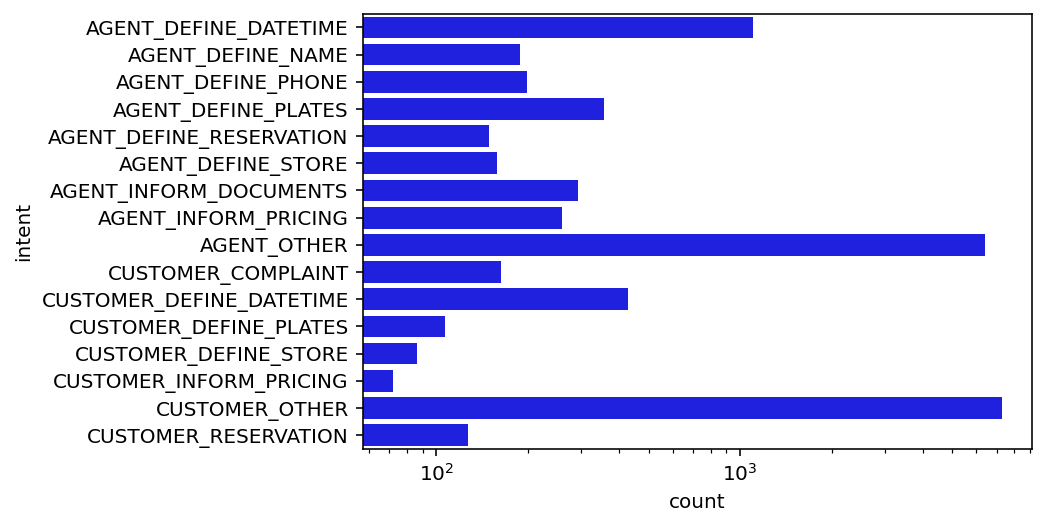

In [ ]:
p = sns.countplot(y = df['intent'], orient='h', color= 'blue', order=classes_names)
#plt.xlabel('review score')
#plt.xticks(rotation=90)
p.set_xscale("log")
print(plt)


In [ ]:
PRE_TRAINED_MODEL_NAME = "nlpaueb/bert-base-greek-uncased-v1" #'bert-base-cased' #
MAX_LEN = 20

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, truncation=True)

sample_txt = 'τι καιρό θα κάνει αύριο ? '

tokens = tokenizer.tokenize(sample_txt)#, truncation= True)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: τι καιρό θα κάνει αύριο ? 
   Tokens: ['τι', 'καιρο', 'θα', 'κανει', 'αυριο', '?']
Token IDs: [410, 1015, 361, 451, 1733, 148]


In [ ]:
%%capture
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=MAX_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True# Return PyTorch tensors
)

encoding.keys()

class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True,
          
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }
    
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df['text'].to_numpy(),
        targets=df['intent_int'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
      )

def plot_history(history):
    %matplotlib inline  
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')

    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show()
#    plt.ylim([0, 1.1]);

    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')

    plt.title('Training history')
    plt.ylabel('Log-Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'dev'], loc='upper right')
    plt.show()



In [ ]:
df_train2, df_test = train_test_split(df, test_size=0.25, stratify=df['intent_int'], random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.4, stratify=df_test['intent_int'],random_state=RANDOM_SEED)


In [ ]:
def undersampling(df_train_many, other_limit=0.1, agent_limit=0.1):
    y_train2 = []
    y_train2_label = []
    x_train2 = []
    yy_train2 = df_train_many['intent_int'].values.tolist()
    yy_train2_label = df_train_many['intent'].values.tolist()
    xx_train2 = df_train_many['text'].values.tolist()
    
    counter1_a, counter1_c, counter2 = 0 , 0, 0
    other_a, other_c = 0,0
    agent = 0
    for i in yy_train2_label:
        if i == 'AGENT_OTHER':
            other_a += 1
        elif i == 'CUSTOMER_OTHER':
            other_c +=1
        elif i == 'AGENT_DEFINE_DATETIME':
            agent += 1
        else:
            pass
    num_other_a = int(other_a*other_limit)
    num_other_c = int(other_c*other_limit)
    num_agent = int(agent*agent_limit)
    for i in range(len(yy_train2)):
        if yy_train2_label[i] == 'AGENT_OTHER':
            counter1_a += 1
            if counter1_a <= num_other_a:
                x_train2.append(xx_train2[i])
                y_train2.append(yy_train2[i])
                y_train2_label.append(yy_train2_label[i])
            else:
                pass
        
        elif yy_train2_label[i] == 'CUSTOMER_OTHER':
            counter1_c += 1
            if counter1_c <= num_other_c:
                x_train2.append(xx_train2[i])
                y_train2.append(yy_train2[i])
                y_train2_label.append(yy_train2_label[i])
            else:
                pass
        
        elif yy_train2_label[i] == 'AGENT_DEFINE_DATETIME':
            counter2 += 1
            if counter2 <= num_agent:
                x_train2.append(xx_train2[i])
                y_train2.append(yy_train2[i])
                y_train2_label.append(yy_train2_label[i])
            else:
                pass
        else:
            x_train2.append(xx_train2[i])
            y_train2.append(yy_train2[i])
            y_train2_label.append(yy_train2_label[i])
    
    df_train_less = pd.DataFrame()
    df_train_less['text'] = x_train2
    df_train_less['intent'] = y_train2_label
    df_train_less['intent_int'] = y_train2
    return df_train_less



(2945, 3)
<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>


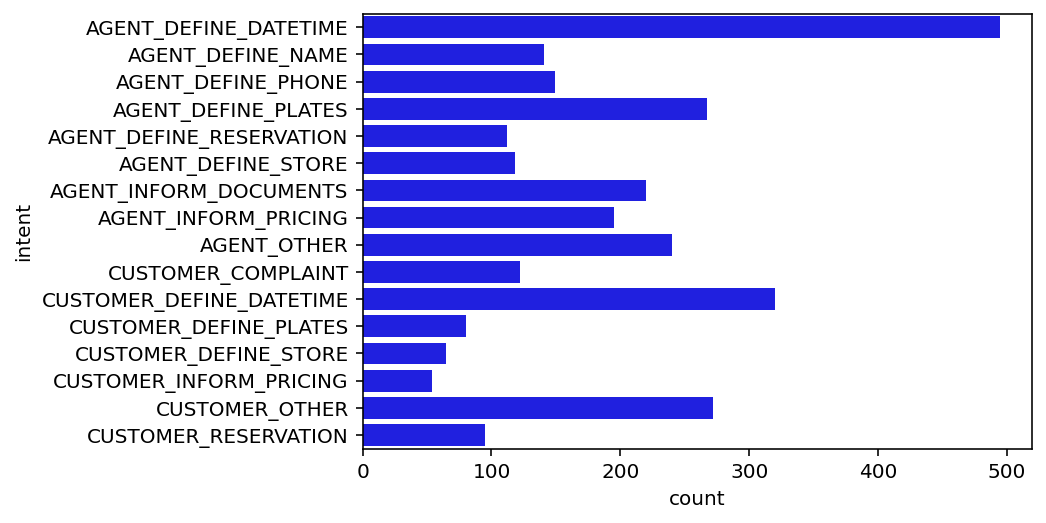

In [ ]:
df_train = undersampling(df_train2, other_limit = 0.05, agent_limit = 0.6)   
print(df_train.shape)
sns.countplot(y = df_train['intent'], orient='h', color= 'blue', order=classes_names)
#plt.xlabel('review score')
#plt.xticks(rotation=90)
print(plt)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>


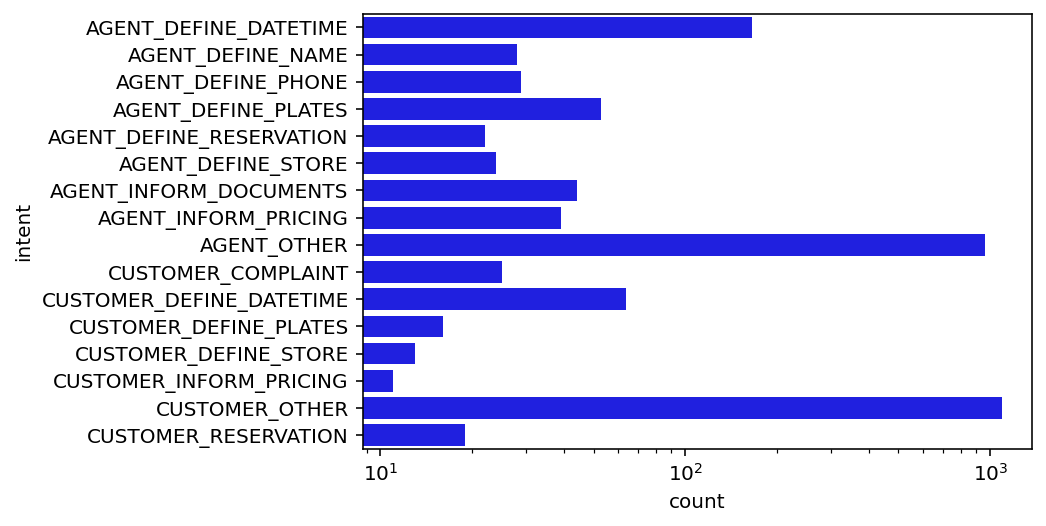

In [ ]:
p = sns.countplot(y = df_val['intent'], orient='h', color= 'blue', order=classes_names)
#plt.xlabel('review score')
#plt.xticks(rotation=90)
p.set_xscale("log")
print(plt)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>


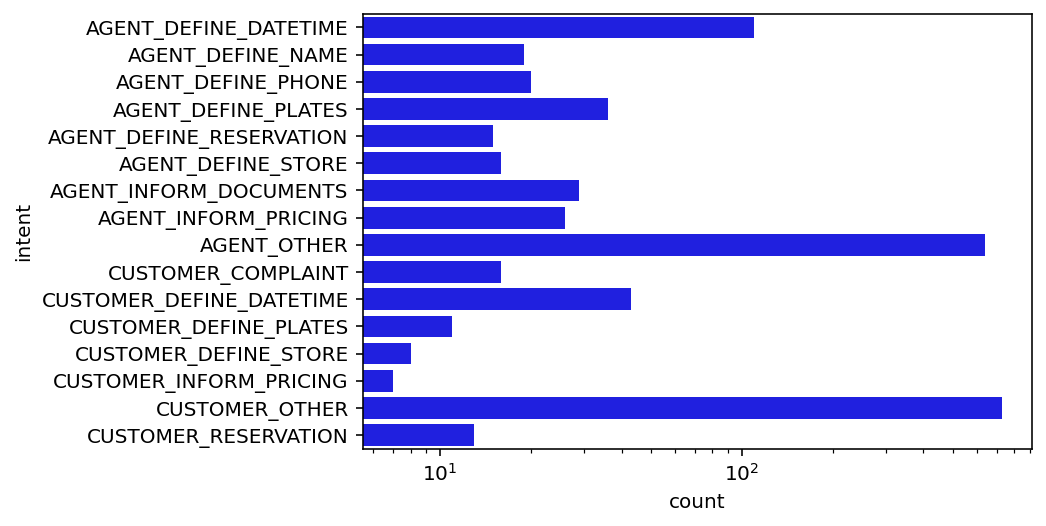

In [ ]:
p = sns.countplot(y = df_test['intent'], orient='h', color= 'blue', order=classes_names)
#plt.xlabel('review score')
#plt.xticks(rotation=90)
p.set_xscale("log")
print(plt)

In [ ]:
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

print(df_train.shape, df_val.shape, df_test.shape)
#(2945, 3) (2604, 3) (1737, 3)


(2945, 3) (2604, 3) (1737, 3)


In [ ]:
data = next(iter(train_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([64, 20])
torch.Size([64, 20])
torch.Size([64])


In [ ]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes, dropout_rate, dense_neurons, hidden):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p = dropout_rate )
        self.hidden_layer = nn.Linear(self.bert.config.hidden_size, dense_neurons)
        self.hidden = hidden
        self.relu = nn.PReLU()
        if self.hidden:
            self.out = nn.Linear(dense_neurons, n_classes)
        else:
            self.out = nn.Linear(self.bert.config.hidden_size,n_classes)
        
    def forward(self, input_ids, attention_mask):
#        self.bert.embeddings.requires_grad = False
 #       for param in self.bert.parameters():
  #          param.requires_grad = False
        
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask)        
        drop_output = self.drop(pooled_output)
        
        if self.hidden:
            hidden_output = self.hidden_layer(drop_output)
            relu_output = self.relu(hidden_output)
            final = self.out(relu_output)
        else:
            final = self.out(drop_output)
        
        return final
    

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([64, 20])
torch.Size([64, 20])


In [ ]:
model3 = SentimentClassifier(len(set(y)), 0.1 , 500 , True)
model3.load_state_dict(torch.load('bert_sentence_nofreeze_final.bin'))
model3 = model3.to(device)


In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    zero, one, two, counter = 0,0,0,0
    rows, cols = 16,4 # classes, (tp, fn, fp, tn)
    my_matrix = [([0]*cols) for i in range(rows)]
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)            

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses) 

In [ ]:
test_acc, test_loss  = eval_model(model3,test_data_loader,loss_fn,device,len(df_test))

print("acc: " , test_acc.item() )
print("loss: " , test_loss.item() )
#acc:  0.4968336211859528
#loss:  1.7029907064778464
    

acc:  0.4968336211859528
loss:  1.7029907064778464


In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=True, yticklabels=True)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=90, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');


                          precision    recall  f1-score   support

   AGENT_DEFINE_DATETIME       0.37      0.72      0.49       110
       AGENT_DEFINE_NAME       0.46      0.95      0.62        19
      AGENT_DEFINE_PHONE       0.57      1.00      0.73        20
     AGENT_DEFINE_PLATES       0.46      0.97      0.62        36
AGENT_DEFINE_RESERVATION       0.33      0.73      0.46        15
      AGENT_DEFINE_STORE       0.70      0.88      0.78        16
  AGENT_INFORM_DOCUMENTS       0.60      0.93      0.73        29
    AGENT_INFORM_PRICING       0.55      1.00      0.71        26
             AGENT_OTHER       0.80      0.42      0.55       641
      CUSTOMER_COMPLAINT       0.08      0.75      0.14        16
CUSTOMER_DEFINE_DATETIME       0.24      0.74      0.37        43
  CUSTOMER_DEFINE_PLATES       0.09      0.82      0.17        11
   CUSTOMER_DEFINE_STORE       0.20      0.75      0.32         8
 CUSTOMER_INFORM_PRICING       0.17      0.57      0.26         7
         

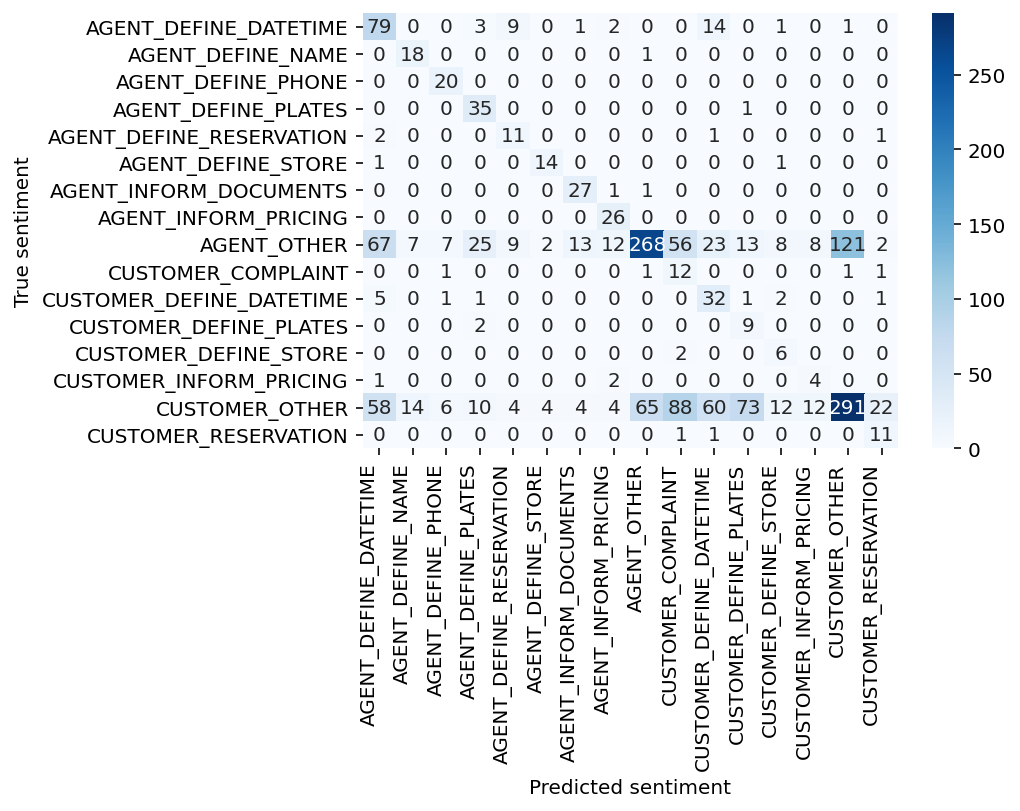

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model3,test_data_loader)
classes_names=sorted(list(set(y)))
print(classification_report(y_test, y_pred, target_names=classes_names))


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes_names, columns=classes_names)
show_confusion_matrix(df_cm)

In [ ]:
print("f1 :", f1_score(y_test, y_pred.tolist(), average='weighted') )
print("loss : ", log_loss(y_test, y_pred_probs.tolist()))
print("acc : ", accuracy_score(y_test, y_pred.tolist()))
print("balanced acc : " , balanced_accuracy_score(y_test, y_pred.tolist()))

#f1 : 0.5261512414855508
#loss :  1.697981857057035
#acc :  0.4968336211859528
#balanced acc :  0.7797163991785706
    

f1 : 0.5261512414855508
loss :  1.697981857057035
acc :  0.4968336211859528
balanced acc :  0.7797163991785706


In [ ]:
pred_onehot = np.zeros((len(y_test),16))
for i in range(len(y_test)):
    if y_test.tolist()[i] in [0,1,2,3,4,5,6,7,8]:
        k = np.argmax(y_pred_probs.tolist()[i][:9])
        pred_onehot[i][k] = y_pred_probs.tolist()[i][k]
    elif y_test.tolist()[i] in [9,10,11,12,13,14,15]:
        k = np.argmax(y_pred_probs.tolist()[i][9:])
        k = k + 9
        pred_onehot[i][k] = y_pred_probs.tolist()[i][k]
    else:
        faults2 += 1

pred_onehot_labels = []
pred_onehot_intlabels = []
for i in range(len(pred_onehot)):
    for j in range(len(classes_names)):
        if pred_onehot[i][j] != 0.:
            pred_onehot_labels.append(classes_names[j])
            pred_onehot_intlabels.append(j)

f1 : 0.7096791198484823
loss :  11.366091607727448
acc :  0.6614853195164075
balanced acc :  0.8660751462145305


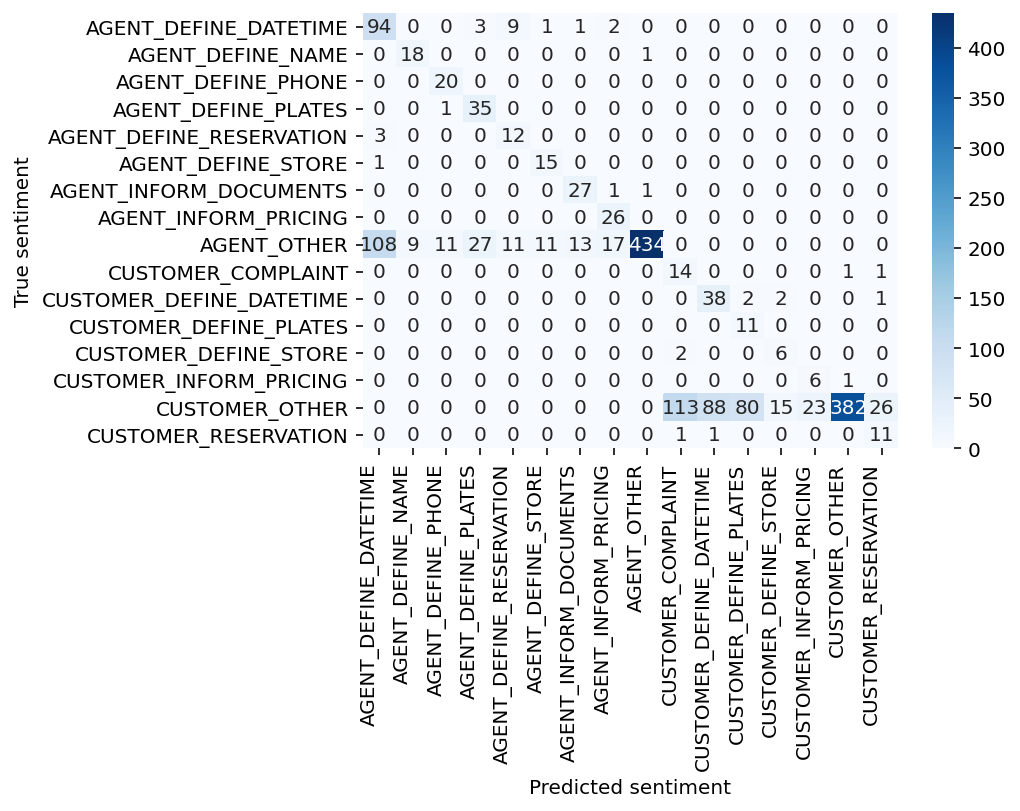

In [ ]:
cm = confusion_matrix(y_test, pred_onehot_intlabels)
df_cm = pd.DataFrame(cm, index=classes_names, columns=classes_names)
show_confusion_matrix(df_cm)

print("f1 :", f1_score(y_test, pred_onehot_intlabels, average='weighted') )
print("loss : ", log_loss(y_test, pred_onehot))
print("acc : ", accuracy_score(y_test, pred_onehot_intlabels))
print("balanced acc : " , balanced_accuracy_score(y_test, pred_onehot_intlabels))
#metrics from fasttext
#f1 : 0.7096791198484823
#loss :  11.366091607727448
#acc :  0.6614853195164075
#balanced acc :  0.8660751462145305
    

για την καρτούλα έρχεστε χωρίσ ραντεβού έχετε άμεση εξυπηρέτηση και
είναι 12 ευρώ το κόστοσ

True sentiment: AGENT_DEFINE_RESERVATION


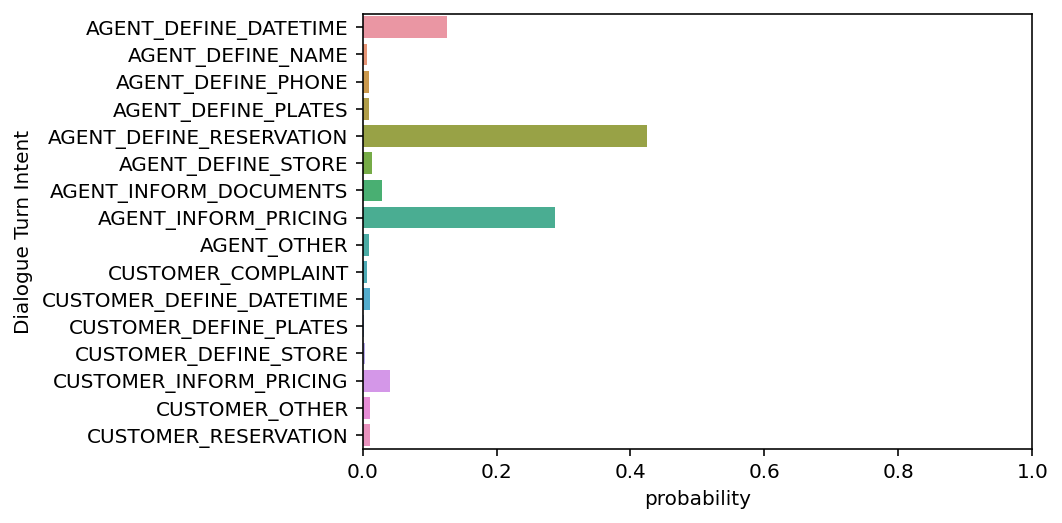

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': classes_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {classes_names[true_sentiment]}')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Dialogue Turn Intent')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
review_text = "είναι 55 ο έλεγχος και ενσωματωμένη η κάρτα καυσαερίων"
#agent inform ricing
encoded_review = tokenizer.encode_plus(review_text,max_length=MAX_LEN,
    add_special_tokens=True,return_token_type_ids=False,
    pad_to_max_length=True,return_attention_mask=True,return_tensors='pt',truncation=True)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model3(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print()
print(f'Sentiment  : {classes_names[prediction]}')

Review text: είναι 55 ο έλεγχος και ενσωματωμένη η κάρτα καυσαερίων

Sentiment  : AGENT_INFORM_PRICING


In [ ]:
y_true2 = []
for i in y_test:
    y_true2.append(classes_names[i])

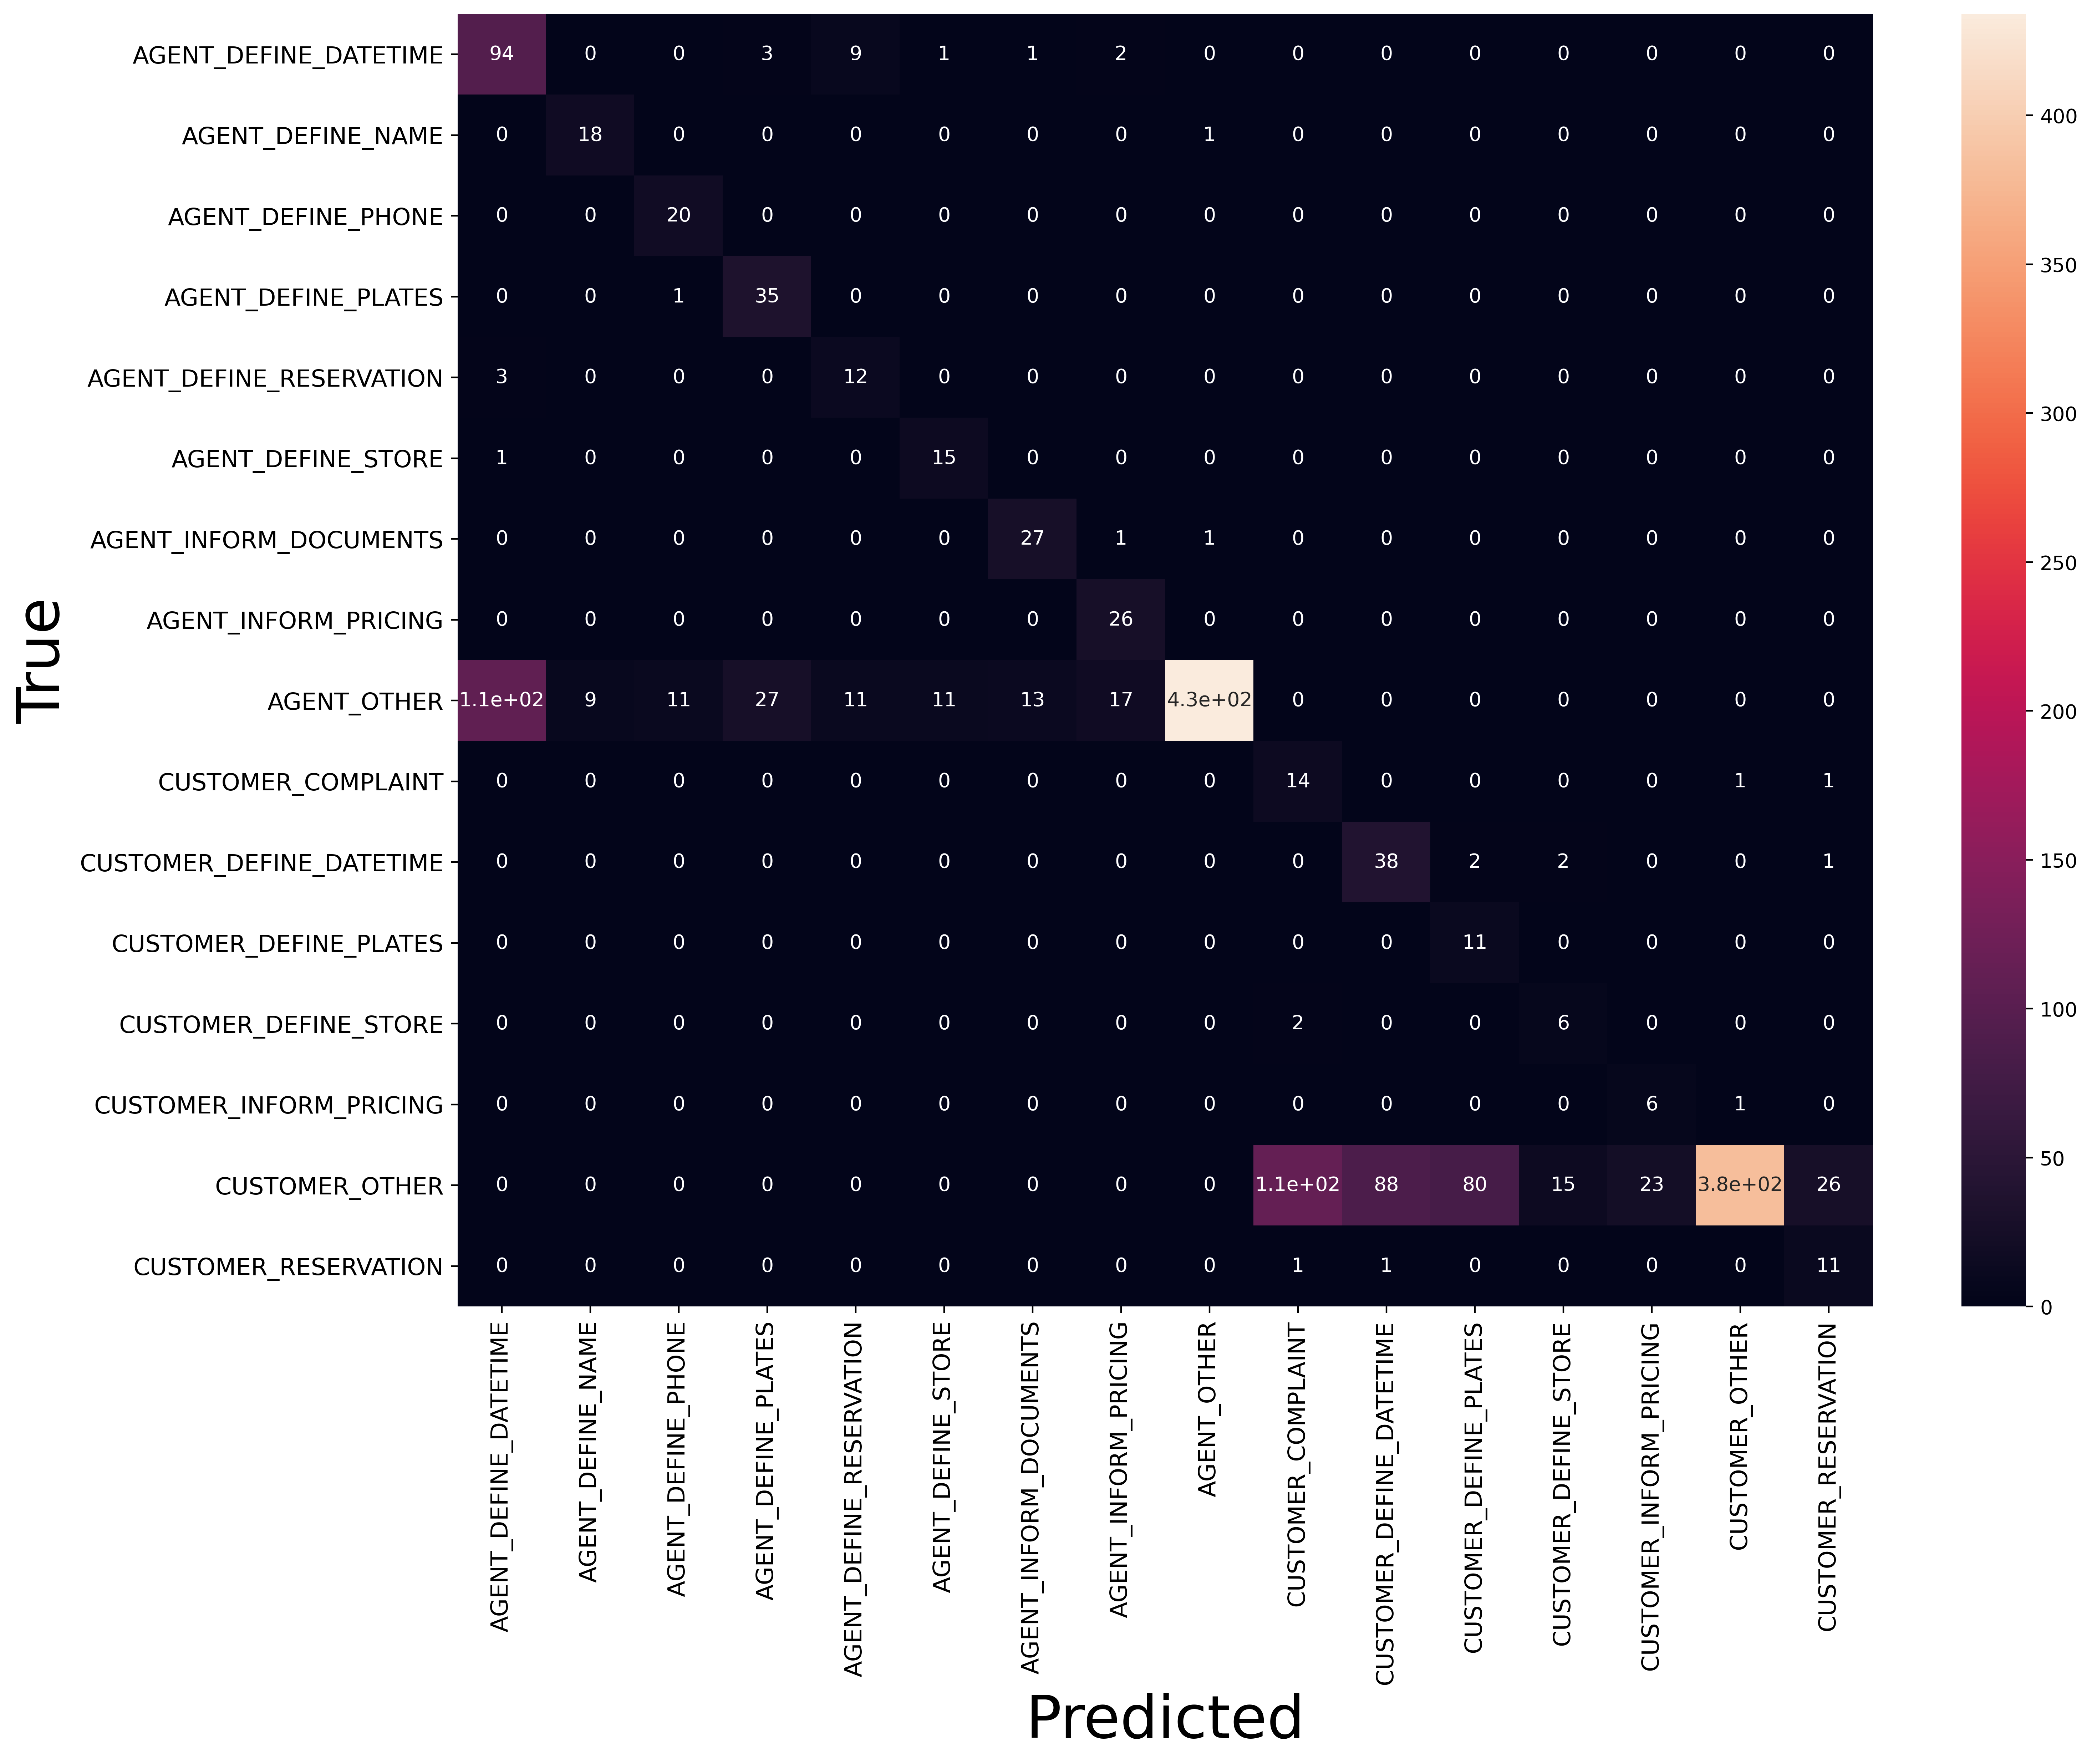

In [ ]:
y_true = pd.Series(y_true2, name='True')
y_pred2 = pd.Series(pred_onehot_labels, name='Predicted')
dialogue_correlation = pd.crosstab(y_true, y_pred2)
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 200 
plt.ylabel("po",fontsize = 30)
plt.xlabel("po",fontsize = 30)
res = sn.heatmap(dialogue_correlation, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)
plt.show()


In [ ]:
y_test_int = []
for i in y_test:
    y_test_int.append(i.item())

len(y_test_int)

1737

In [ ]:
y_test_popo = [] #test for int labels
y_pred_without_other = []
y_pred_probs_without_other_16 = []
for i in range(len(y_test_int)):
    if y_test_int[i] == 8:
        pass
    elif y_test_int[i] == 14:
        pass
    else:
        y_pred_without_other.append(y_pred[i])       
        y_test_popo.append(y_test_int[i])
        y_pred_probs_without_other_16.append(y_pred_probs[i])

faults2 = 0
y_test_without_other = []
for i in y_test_popo:
    if i < 8 :
        y_test_without_other.append(i)
    elif i < 14 and i > 7:
        y_test_without_other.append(i-1)
    elif i == 15:
        y_test_without_other.append(i-2)
    else:
        faults2 +=1
faults2

0

In [ ]:
print(len(set(y_test_without_other)))


14


In [ ]:
y_test_po = []
for i in y_test:
    y_test_po.append(i.item())
Counter(y_test_po)

Counter({14: 727,
         4: 15,
         10: 43,
         8: 641,
         3: 36,
         0: 110,
         5: 16,
         7: 26,
         15: 13,
         11: 11,
         1: 19,
         2: 20,
         13: 7,
         9: 16,
         6: 29,
         12: 8})

In [ ]:
Counter(y_test_without_other)

Counter({4: 15,
         9: 43,
         3: 36,
         0: 110,
         5: 16,
         7: 26,
         13: 13,
         10: 11,
         1: 19,
         2: 20,
         12: 7,
         8: 16,
         6: 29,
         11: 8})

In [ ]:
len(y_test_without_other)

369

In [ ]:
po = np.stack(y_pred_probs_without_other_16,axis=1)
y_pred_probs_without_other1 = np.delete(po, 14, 0)
y_pred_probs_without_other2 = np.delete(y_pred_probs_without_other1, 8, 0)
y_pred_probs_without_other = np.stack(y_pred_probs_without_other2,axis=1)
y_pred_probs_without_other.shape


(369, 14)

In [ ]:
faults3 = 0
pred_onehot_without_other = np.zeros((len(y_test_without_other),14))
for i in range(len(y_test_without_other)):
    if y_test_without_other[i] in [0,1,2,3,4,5,6,7]:
        k = np.argmax(y_pred_probs_without_other[i][:8])
        #pred_onehot_without_other[i][k] = y_pred_probs_without_other.tolist()[i][k]
        pred_onehot_without_other[i][k] = 1
    elif y_test_without_other[i] in [8,9,10,11,12,13,14]:
        k = np.argmax(y_pred_probs_without_other[i][8:])
        k = k + 8
        #pred_onehot_without_other[i][k] = y_pred_probs_without_other.tolist()[i][k]
        pred_onehot_without_other[i][k] = 1
    else:
        faults3 += 1

faults3

0

In [ ]:
classes_names_without_other = np.array(copy.copy(classes_names))
classes_names_without_other = np.delete(classes_names_without_other,14,0)
classes_names_without_other = np.delete(classes_names_without_other,8,0)
classes_names_without_other = sorted(list(classes_names_without_other))

In [ ]:
classes_names_without_other

['AGENT_DEFINE_DATETIME',
 'AGENT_DEFINE_NAME',
 'AGENT_DEFINE_PHONE',
 'AGENT_DEFINE_PLATES',
 'AGENT_DEFINE_RESERVATION',
 'AGENT_DEFINE_STORE',
 'AGENT_INFORM_DOCUMENTS',
 'AGENT_INFORM_PRICING',
 'CUSTOMER_COMPLAINT',
 'CUSTOMER_DEFINE_DATETIME',
 'CUSTOMER_DEFINE_PLATES',
 'CUSTOMER_DEFINE_STORE',
 'CUSTOMER_INFORM_PRICING',
 'CUSTOMER_RESERVATION']

In [ ]:
faults4 = 0
#classes_names_without_other = sorted(list(set(y_test_without_other)))
pred_onehot_labels_without_other = []
pred_onehot_intlabels_without_other = []
for i in range(len(pred_onehot_without_other)):
    for j in range(len(classes_names_without_other)):
        if pred_onehot_without_other[i][j] != 0.:
            pred_onehot_labels_without_other.append(classes_names_without_other[j])
            pred_onehot_intlabels_without_other.append(j)


f1 : 0.9123181934041052
loss :  3.0888336613334895
acc :  0.9105691056910569
balanced acc :  0.9223340668509072


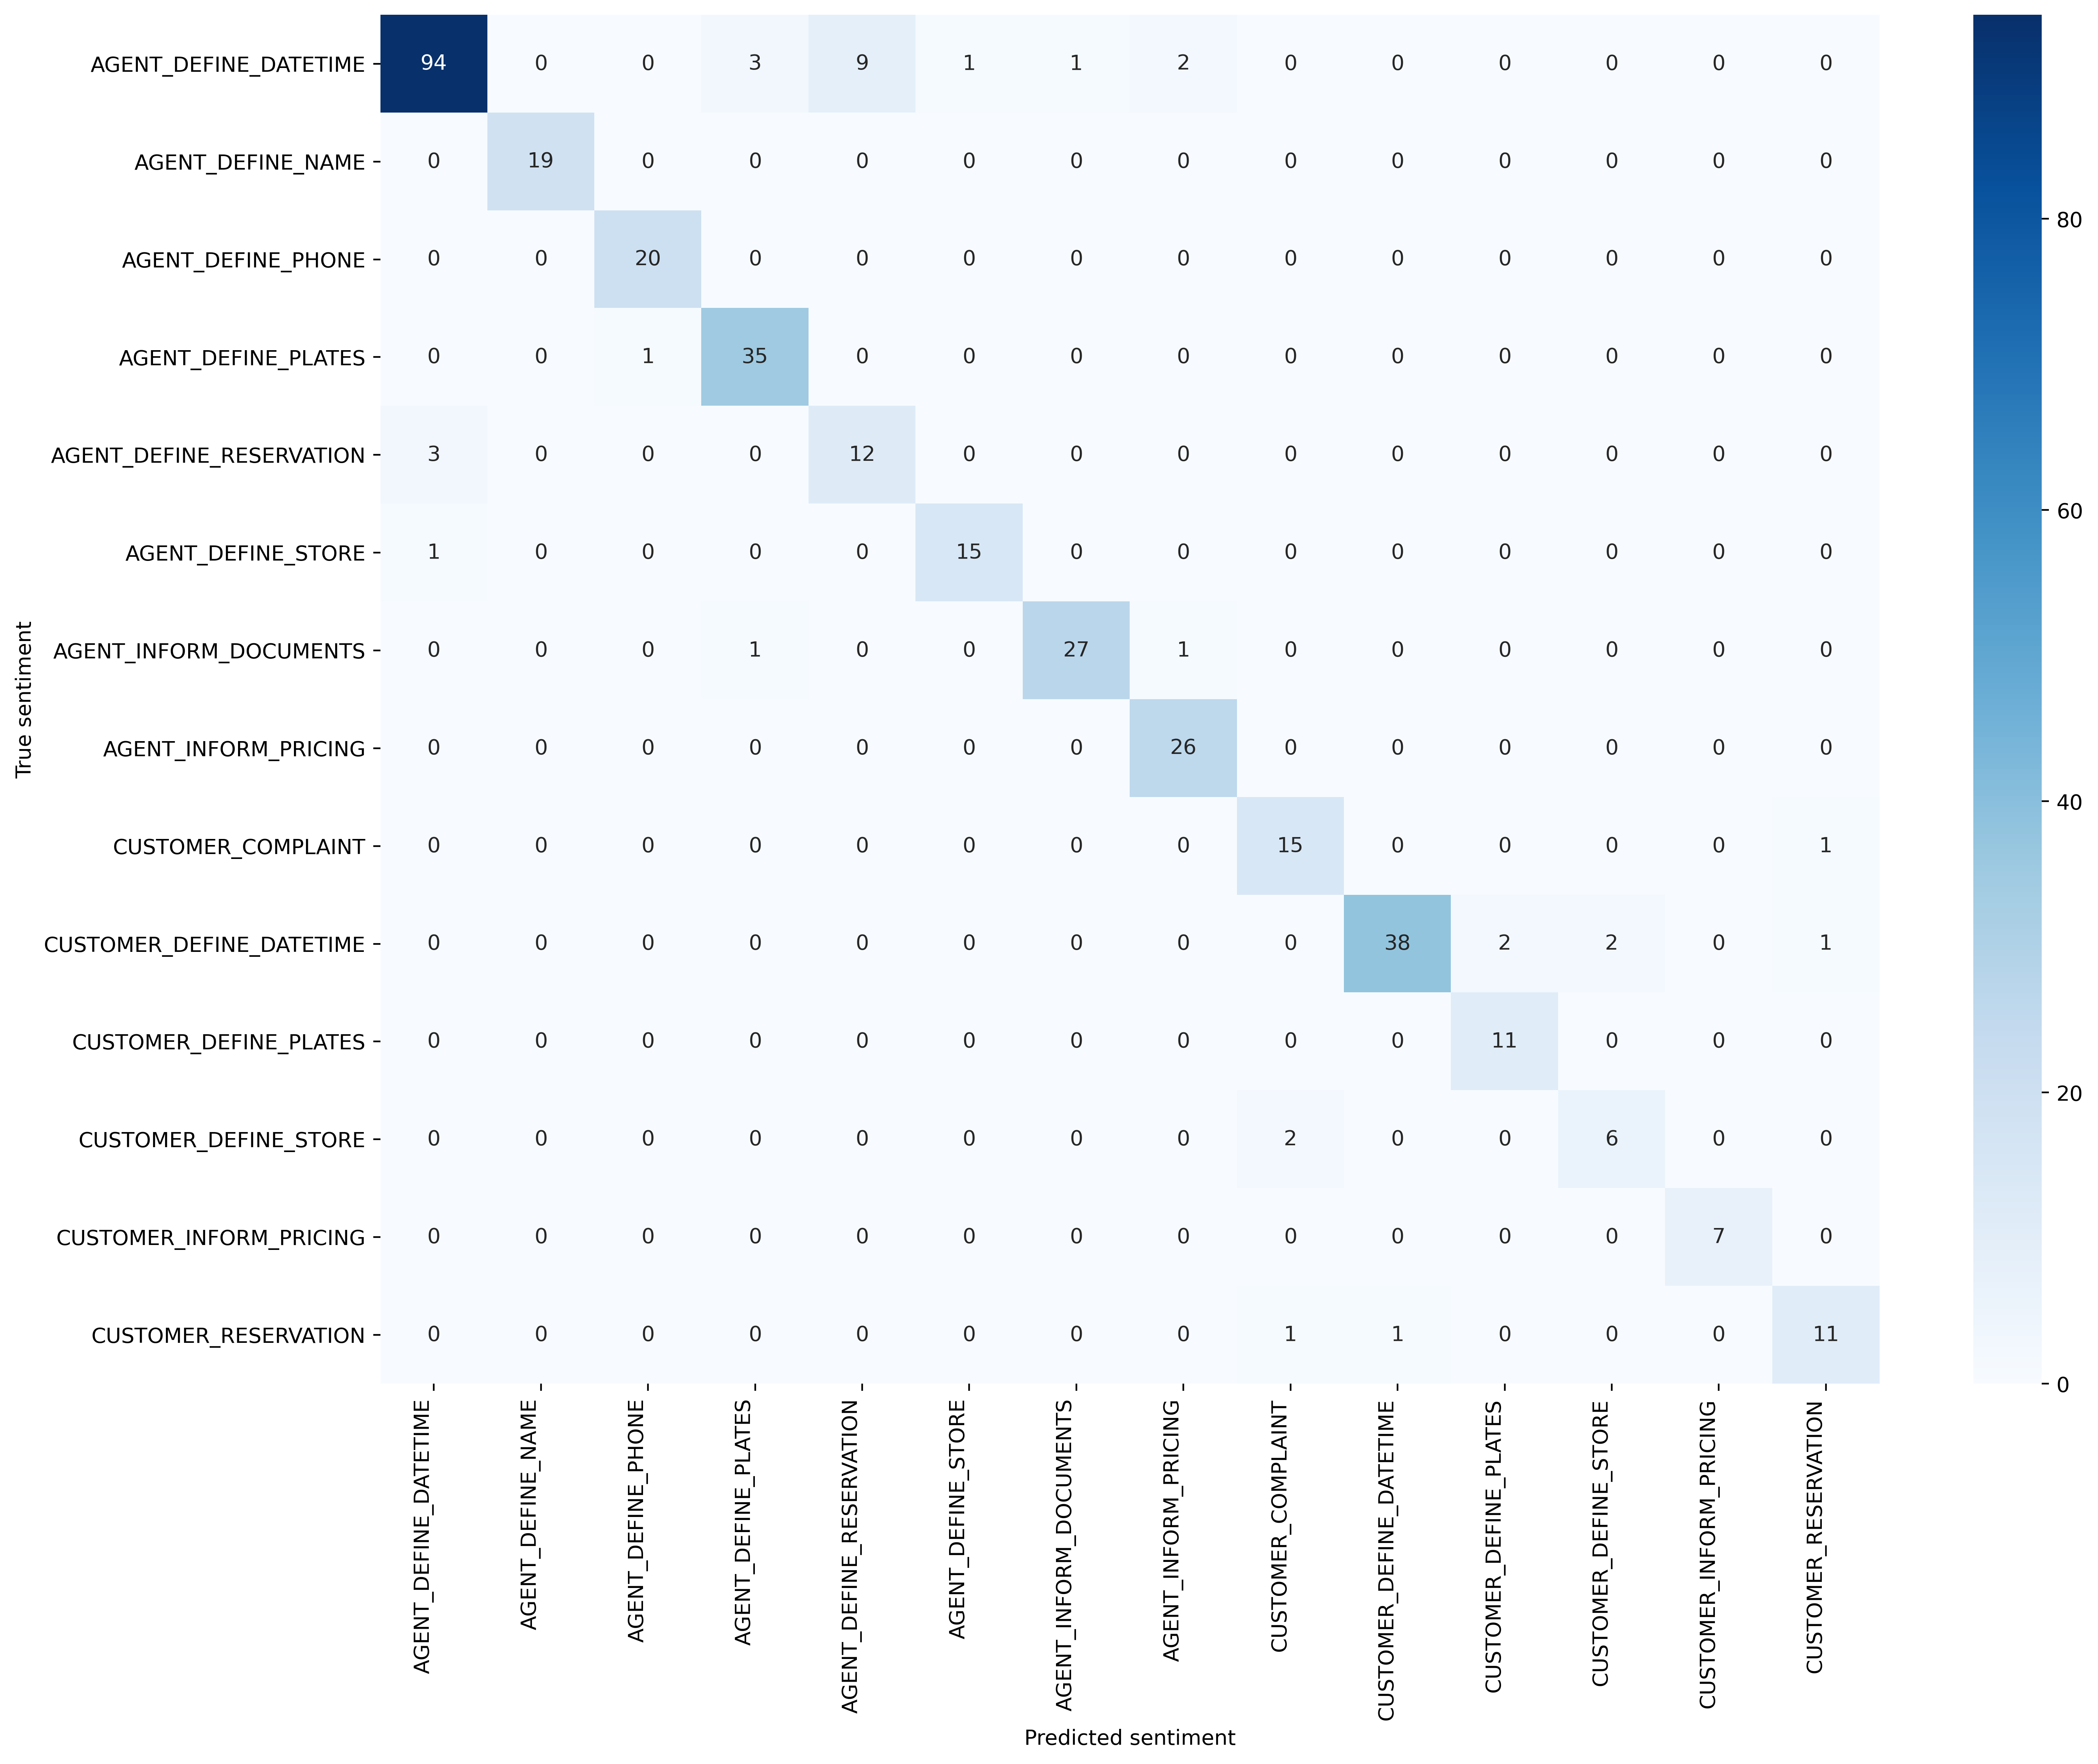

In [ ]:
cm_without_other = confusion_matrix(y_test_without_other, pred_onehot_intlabels_without_other)
df_cm_without_other = pd.DataFrame(cm_without_other, index=classes_names_without_other, columns=classes_names_without_other)
show_confusion_matrix(df_cm_without_other)

print("f1 :", f1_score(y_test_without_other, pred_onehot_intlabels_without_other, average='weighted') )
print("loss : ", log_loss(y_test_without_other, pred_onehot_without_other))
print("acc : ", accuracy_score(y_test_without_other, pred_onehot_intlabels_without_other))
print("balanced acc : " , balanced_accuracy_score(y_test_without_other, pred_onehot_intlabels_without_other))
#metrics from fasttext
#f1 : 0.7096791198484823
#loss :  11.366091607727448
#acc :  0.6614853195164075
#balanced acc :  0.8660751462145305
    

In [ ]:
y_test_without_other_labels = []
for i in y_test_without_other:
    y_test_without_other_labels.append(classes_names_without_other[i])

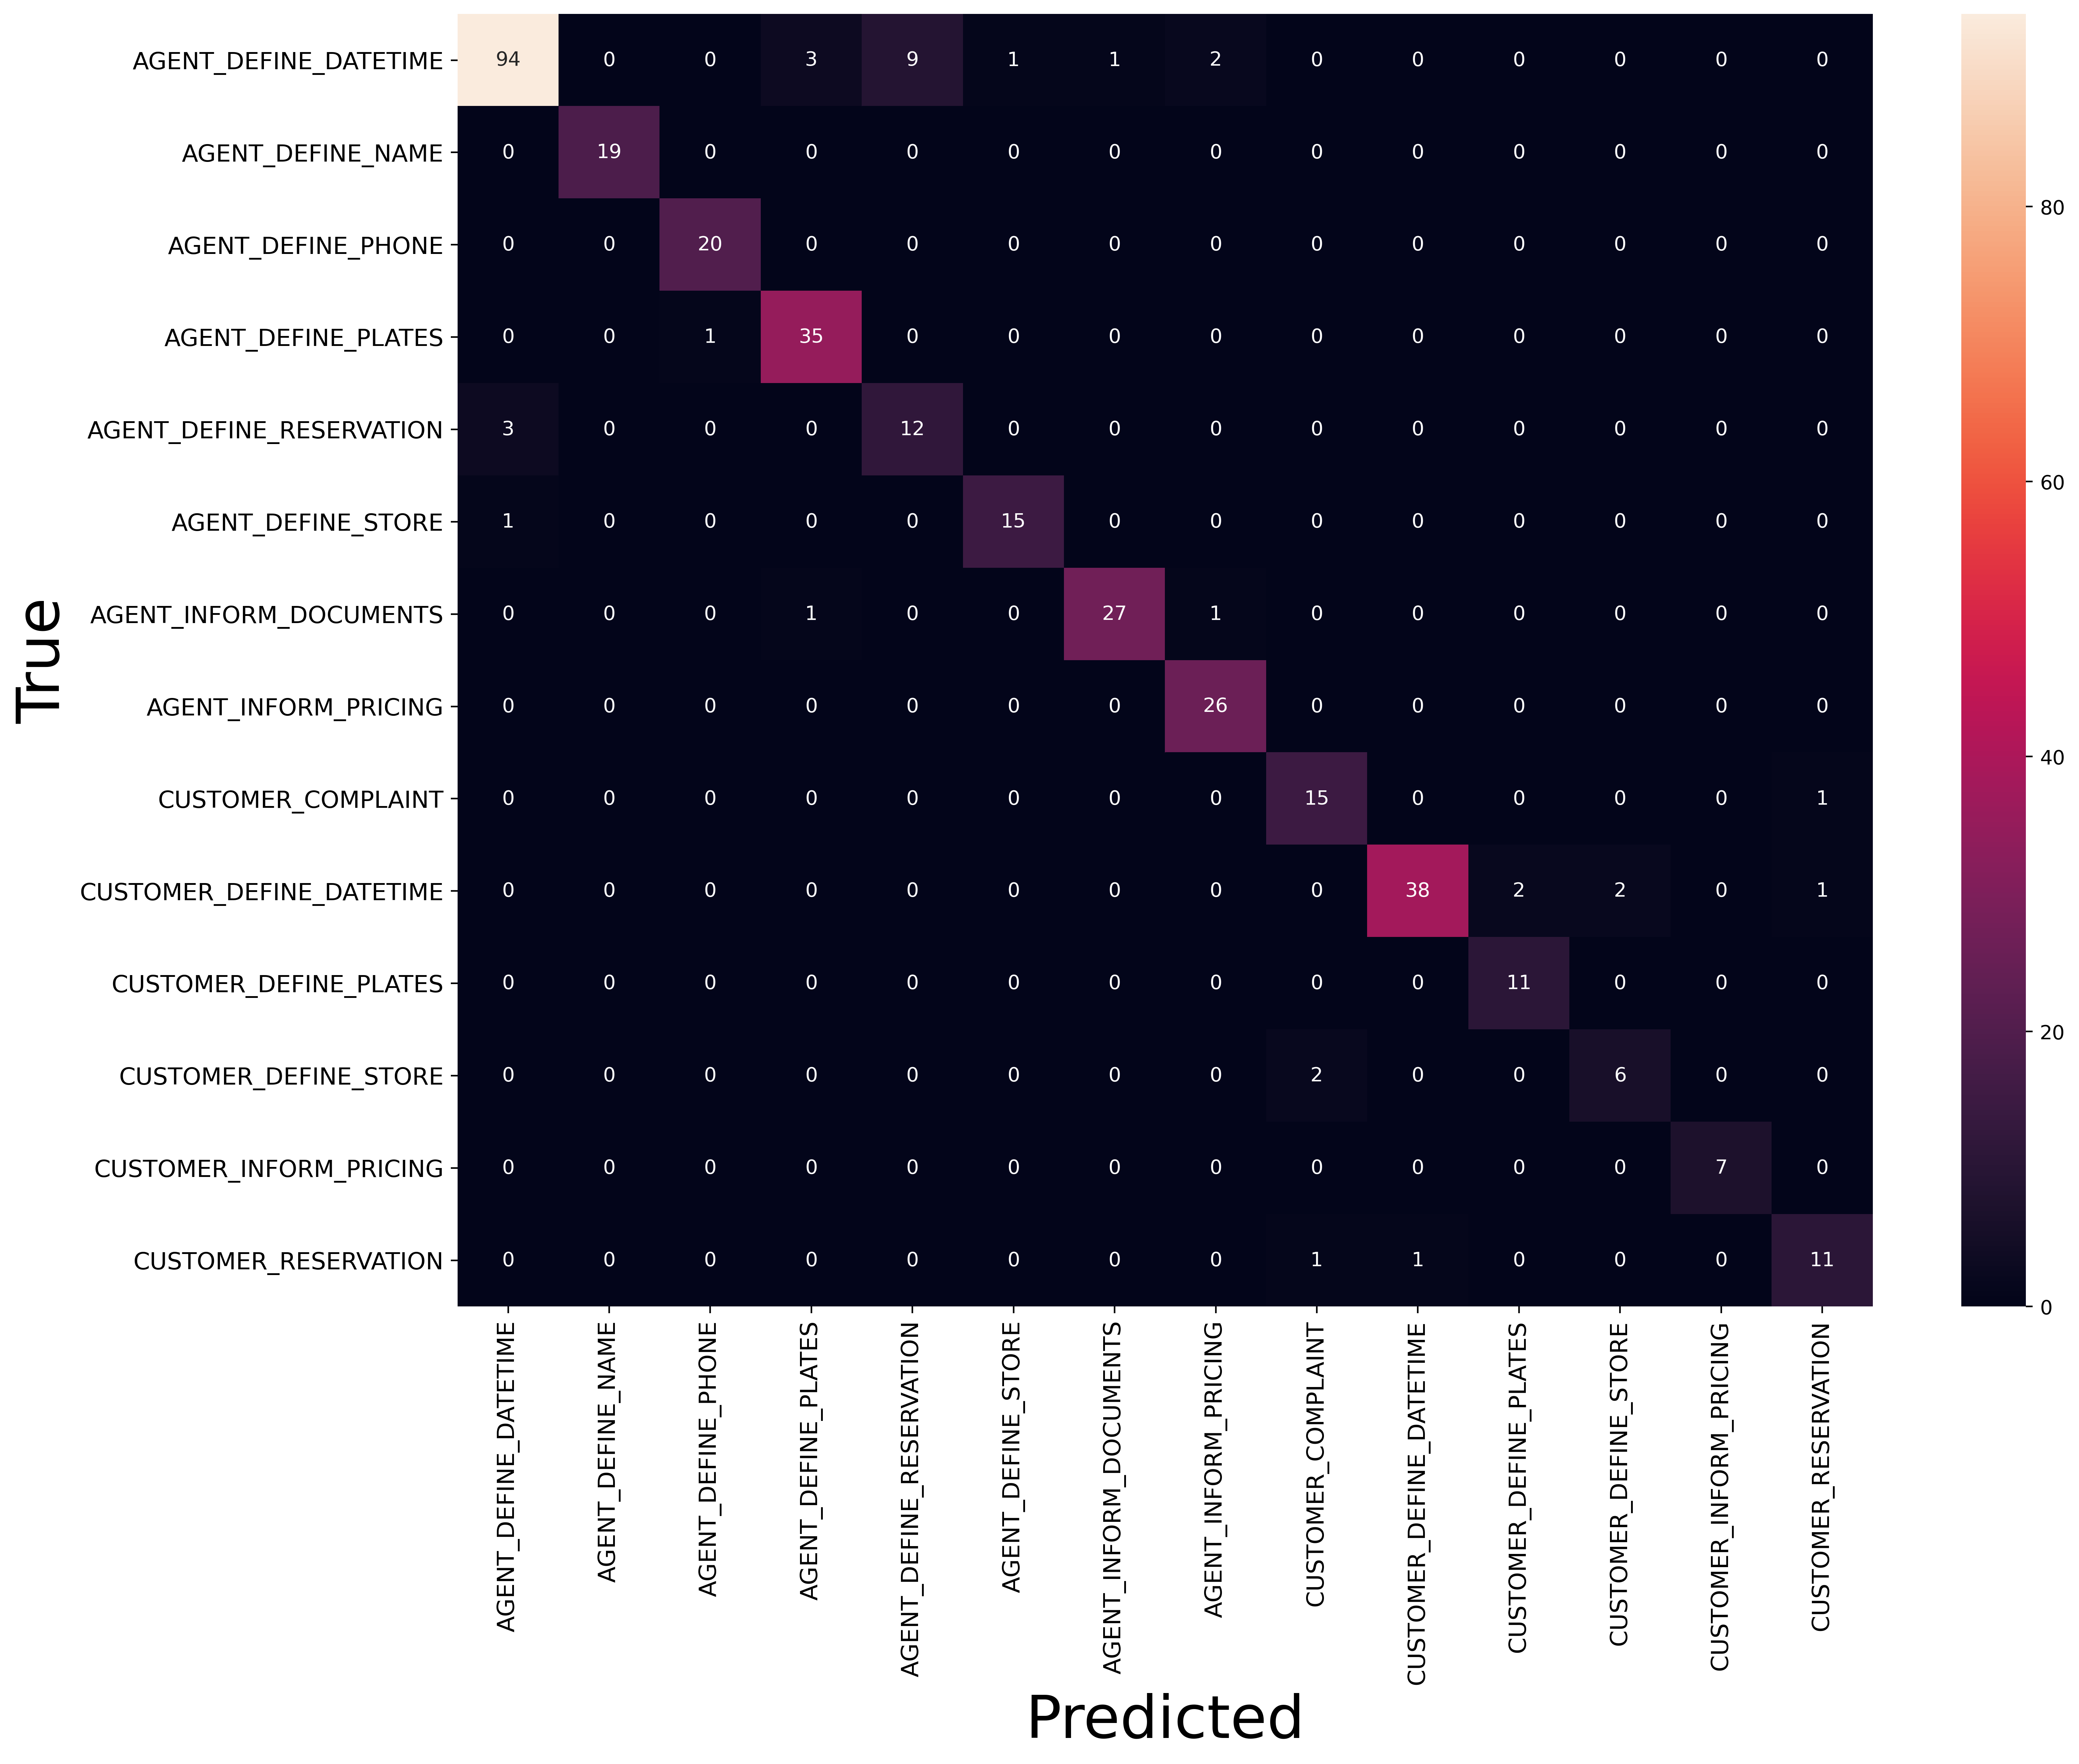

In [ ]:
y_true_final = pd.Series(y_test_without_other_labels, name='True')
y_pred_final = pd.Series(pred_onehot_labels_without_other, name='Predicted')
dialogue_correlation_final = pd.crosstab(y_true_final, y_pred_final)
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 200 
plt.ylabel("po",fontsize = 30)
plt.xlabel("po",fontsize = 30)
res = sn.heatmap(dialogue_correlation_final, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)
plt.show()
